In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("..")
from src.dataset import SIModel
import seaborn as sns
from scipy.optimize import minimize_scalar

In [43]:
sns.set_theme()
beta_true = .15
alpha = 0.1
gamma = 0.05
N = 100
T = 52

In [44]:
def simulator(alpha, beta, gamma, N, T):
    X  = np.empty((N, T))
    X[:, 0] = np.random.binomial(1, alpha, N)
    for t in range(1, T):
        I = X[:, t-1]
        # components dependent on individual covariates
        hazard = I.sum() * beta * np.ones(N)
        p = 1 - np.exp(-hazard / N)
        new_infections = np.random.binomial(1, p, N)
        X[:, t] = np.where(I, np.ones(N), new_infections)
        discharge = np.random.binomial(1, gamma, N)
        screening = np.random.binomial(1, alpha, N)
        X[:, t] = np.where(discharge, screening, X[:, t])
    return X

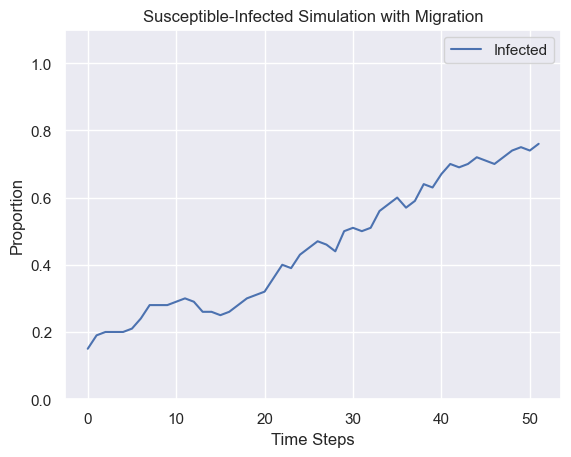

In [45]:
X_o = simulator(alpha, beta_true, gamma, N, T)
I_o = X_o.sum(0).astype(int)
plt.plot(I_o / N, label="Infected")
plt.legend(loc="upper right")
plt.xlabel("Time Steps")
plt.ylabel("Proportion")
plt.ylim(0, 1.1)
plt.title("Susceptible-Infected Simulation with Migration")
plt.show()

In [46]:
def x_loglikelihood(beta, alpha, gamma, N, T, X):
    ans = np.log(
        alpha ** X_o[:, 0] * (1 - alpha) ** (1 - X_o[:, 0])
        ).sum()
    for t in range(1, T):
        xs = X[:, t-1]
        xt = X[:, t]
        Is = X[:, t-1].sum()
        ans += (xt * xs  * np.log(
            gamma * alpha + (1 - gamma)
        )).sum()
        ans += (xt * (1 - xs)  * np.log(
            gamma * alpha + (1 - gamma) * (1 - np.exp(- beta * Is / N))
        )).sum()
        ans += ((1 - xt) * xs  * np.log(
            gamma * (1 - alpha) + 1e-8
        )).sum()
        ans += ((1 - xt) * (1 - xs) * np.log(
            gamma *(1 - alpha) + (1 - gamma) * (np.exp(- beta * Is / N))
        )).sum()
    return ans         
    

In [48]:
def h(beta):
    return - x_loglikelihood(beta, alpha, gamma, N, T, X_o)

res = minimize_scalar(h, bounds=(0.01,1), method="bounded")
res.x

0.14811826814237186